In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import uproot, os, pickle
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import plot_tree

In [2]:
file = uproot.open("../Data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root")
tree = file['tree']
ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x trueKs".split(" ")
features = ML1 + ML2
df = tree.pandas.df(features, entrystop = 3 * 10 ** 6)
df_label = df['trueKs']
df.drop('trueKs', axis = 1, inplace = True)

In [3]:
from sklearn.model_selection import train_test_split
test_ratio = 0.2
df_train, df_test, label_train, label_test = train_test_split(df, df_label, test_size = test_ratio)

In [4]:
from scipy.optimize import minimize
class fisher():

    def predict(self,x):
        proj = x@self.w
        return np.where(proj<self.cut,1,0)
    
    def predict_proba(self, x):
        return x @self.w
        
    def fit(self,x,y):
        self.w = np.linalg.inv(x[y==0].cov() + x[y==1].cov())@(x[y==0].mean(axis=0) - x[y==1].mean(axis=0))
        proj = x@self.w
        def gini(cut):
            if (proj<cut[0]).sum() != 0:
                p1 = (y[proj<cut[0]] == 1).sum()/(proj<cut[0]).sum()
            else:
                p1 = 0
            if (proj>=cut[0]).sum() != 0:
                p2 = (y[proj>=cut[0]] == 1).sum()/(proj>=cut[0]).sum()
            else:
                p2 = 0
#             print(cut[0],2*p1*(1-p1) + 2*p2*(1-p2))
            return -((proj<cut[0]).sum()*2*p1*(1-p1) + (proj>=cut[0]).sum()*2*p2*(1-p2))/len(proj)
        m = minimize(gini,[-2],options={'eps':0.005})
        self.cut = m.x

In [5]:
class cla_cuts():
    def predict(self, df):
        return ((df['cosTheta'] > 0.9875)&(df['v0_chi2'] < 10.617)&(df['v0_rxy'] < 442.2810) == 1).astype(int)

In [6]:
import time
start = time.time()

fisc = fisher()
print("fisc: " time.time() - start)
start = time.time()
cutt = cla_cuts()
start = time.time()
tree = DT(max_depth = 10)
print("Tree: " time-time() - start)

In [7]:
fisc.fit(df_train, label_train)

In [8]:
tree.fit(df_train, label_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:
fisc_score = fisc.predict_proba(df_test)
tree_score = tree.predict_proba(df_test)
cutt_score = cutt.predict(df_test)

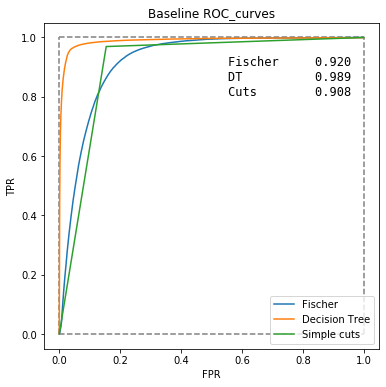

In [28]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.set(title = "Baseline ROC_curves", xlabel = "FPR", ylabel = "TPR")

# Fisc
from sklearn.metrics import roc_curve, roc_auc_score
x, y, _ = roc_curve(label_test, - fisc_score)
fisc_auc = roc_auc_score(label_test, - fisc_score)
ax.plot(x, y, label = "Fischer")


x, y, _ = roc_curve(label_test, tree_score[:, 1])
tree_auc = roc_auc_score(label_test, tree_score[:, 1])
ax.plot(x, y, label = "Decision Tree")


x, y, _ = roc_curve(label_test, cutt_score == 1)
ax.plot(x, y, label = "Simple cuts")
cutt_auc = roc_auc_score(label_test, cutt_score == 1)

import sys 
sys.path.append("py_files/")
from ExternalFunctions import nice_string_output, add_text_to_ax

d = {"Fischer": fisc_auc, \
     "DT":      tree_auc, \
     "Cuts":    cutt_auc}

add_text_to_ax(0.55, 0.9, nice_string_output(d), ax)

ax.vlines([0,1], 0, 1, ls = '--', color = "gray", zorder = -1)
ax.hlines([0,1], 0, 1, ls = '--', color = "gray", zorder = -1)

ax.legend(loc = "lower right")


fig.savefig("figures/roc_baseline.pdf")